In [1]:
# notebook imports
import numpy as np

from scipy.optimize import minimize
import scipy.stats as stats
from IPython.display import display, Math

import matplotlib.pyplot as plt
%matplotlib inline

try:
    import numdifftools as ndt
except:
    !pip install numdifftools

# Maximum Likelihood

In Lecture 3, we looked at a specific method for modeling (or fitting) data, called least-squares. As mentioned, the least-squares method inherently assumes that the data have errors that are normally distributed, i.e., we measure some value $y_i$ that is actually

$$
y_i = y_{true} + \epsilon_i \nonumber
$$

where the $\epsilon_i$ represents a realisation of the noise. In least-squares, we expect that $\epsilon_i$ is randomly drawn from a normal distribution, $\mathcal{N}(0,\sigma^2)$.


Maximum likelihood helps us to extend data analysis to situations where the uncertainties on the data cannot be modeled with a normal distribution.



## MLE example - a straight line with normally distributed errors 

Let us now look at an example of fitting a model to a data set where the values of $y$ depend upon $x$ in a linear fashion. 

In this 'experiment', there is an uncertainty on our $y$ values that are known to follow a normal distribution. We will also assume that each measurement of $y$ has the same value of $\sigma$.


We will generate noisy data for a straight line, $y = \alpha+\beta x$ with true values of $\alpha = 5$ and $\beta = 1$, and $\sigma =1$.

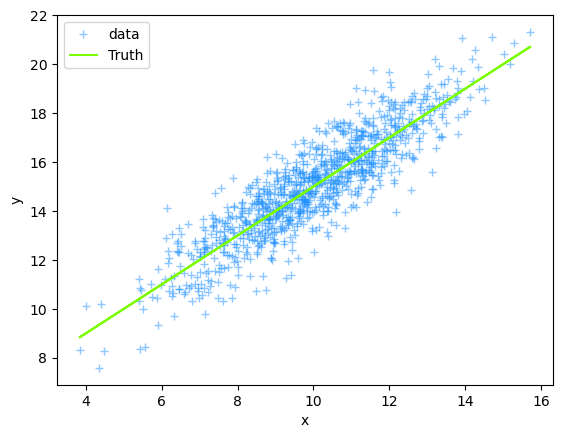

In [3]:
# Generate data

N = 1000 # Number of data points

alpha_true = 5 # intercept
beta_true = 1 # gradient
sigma_true = 1 # standard deviation

# draw random x values
x = 10 + 2*np.random.RandomState(7).randn(N)

# calculate true y-valuse
y = alpha_true + beta_true*x

# add some normally distributed noise to y values
y += sigma_true*np.random.randn(N)

_ = plt.plot(x, y, '+', alpha=0.5, color='dodgerblue', label='data')
_ = plt.plot(x, alpha_true + beta_true*x, 'lawngreen', label='Truth')
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.legend()


### Define the likelihood
For the above data, we have made a measurement $y_i$ (our dependent variable) at each point $x_i$ (our independent variable). 

Our inclination (maybe informed by our theoretical understanding of the physics) suggests the data should obey a straight line. Hence, we want to describe our dependent variable with a linear model,

$$
M(\mathbf{\theta},x_i)=y_{mod}(\mathbf{\theta},x_i)=\theta_0+\theta_1 x_i, \nonumber
$$ 

and we need to determine the parameters of the model, $\mathbf{\theta}=\{\theta_0, \theta_1\}$. Here we will also try to estimate the level of the noise in the data, $\sigma$ (assuming it is the same for all data points); so there will really be three parameters to estimate ($\theta_2=\sigma$).

Hence, we believe the data at $x_i$ is related to $y_i$ via a linear relationship, and that the values of $y_i$ are distributed about their true value, with the spread obeying a Normal distribution.


Let us tackle this problem numerically.

In the Lecture we derived analytically that the log likelihood is given by Eq. 4.5. Many numerical routines are minimisers, then we will want to minimise the negative of the log-likelihood. This is also sometimes multiplied by an additional factor of 2, which leaves us with

$$
-2 \ln \mathcal{L}= n\log{(2\pi\theta_2^2)} + \sum_{i=1}^n\frac{\left[y_{i}-y_{mod}(\mathbf{\theta})\right]^2}{\theta_2^2} \nonumber
$$


Lets look at how we can minimise the negative log-likelihood in Python. In principle, our problem has an analytic solution - but most problems will not (or it won't be easy to solve).

**It is worth noting here that, if possible, it always better to find an analytic solution to estimate the parameters. Analytic solutions are exact and require minimal computational resources. The numerical approach is approximate and may require many evaluations of the likelihood.**


### Numerical evaluation of likelihood

In order to estimate the best model parameters (or point estimates) with the MLE, we first need to define a function that will calculate the negative log-likelihood. With least-squares modules in Python, such as <font face = "menlo" >curve_fit</font>, the log likelihood is already pre-defined for you, i.e. in the module code.

For our straight line there are 3 parameters we want to calculate: 
- $\theta_0$ - the intercept ($\alpha$), 
- $\theta_1$ - the gradient ($\beta$),
- $\theta_2$ - the measurement uncertainty ($\sigma$).

Hence, we write our model for the data as $\mathcal{N(\mu, \sigma)}$, where $\mu = \alpha+\beta x$ and represents the function we want to fit to the data.

Hence, a function for our negative log-likelihood with a linear model is:

In [3]:
def linear_mod(theta, x):
    alpha = theta[1]
    beta = theta[2]
    return alpha + beta * x

In [4]:
def neg_loglike(theta, x, y, model):
    """
    Return Gaussian negative log-likelihood for unknown sigma

    Parameters
    ----------
    theta - model parameters, theta[0] should always be the estimate for sigma
    x - 1d array
        x values of data
    y - 1d array
        y values of data
    model - function 
            model to fit to the data
    """

    sigma = theta[0]
    N = len(x)
    mu = model(theta, x)

    # this is Equation given above
    ll = -N/2 * np.log(2*np.pi*sigma**2) - \
        (1/(2*sigma**2)) * np.sum(np.square(y - mu))

    return -1 * ll   # note - no factor of 2 here

In [5]:
print("Calculating log-likelihood for guesses of model parameters")

guess_params = [4, 1, 2]
print("\n - log L = {0:.2f} for theta = {1},".format(
    neg_loglike(guess_params, x, y, linear_mod), '(4, 1, 2)'))

guess_params = [5, 1.5, 1.5]
print("\n - log L = {0:.2f} for theta = {1},".format(
    neg_loglike(guess_params, x, y, linear_mod), '(5, 1.5, 1.5)'))

Calculating log-likelihood for guesses of model parameters

 - log L = 3534.00 for theta = (4, 1, 2),

 - log L = 2606.36 for theta = (5, 1.5, 1.5),


As shown above, the negative log-likelihood returns a single value for guesses of the model parameters. The size of the likelihood value also depends on the number of data points you have (more data points, larger values of $-\ln\mathcal{L}$ - you can try this yourself by changing N in the data generation cell).

The next step is to *minimise our log-likelihood function*, conditioned on the data. For this, we can use [```scipy.optimise.minimise```](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). This package can minimise a function via a number of numerical methods (or solvers), here we will use the [Nelder-Mead method](https://en.wikipedia.org/wiki/Nelder–Mead_method). Most of theses are similar in principle to the Levenberg-Marquardt discussed in the 3rd lecture, i.e. a gradient descent method.

You can find the list of potential solvers on the SciPy pages. Each solver has its own limitations and the solver you choose will depend on the problem you want to solve [3].

In the 3rd lecture, we also discussed the $\chi^2$ surface. For MLE, we often refer to the likelihood surface instead. As with the Levenberg-Marquardt method, we have to provide an initial guess for our parameters in order to tell the solver where to start on the likelihood surface. 

In [6]:
# guess parameters
theta_start = np.array([1, 1, 1])

res = minimize(neg_loglike, theta_start, method='Nelder-Mead',
               options={'disp': True}, args=(x, y, linear_mod))

Optimization terminated successfully.
         Current function value: 1424.130927
         Iterations: 114
         Function evaluations: 196


We have printed the operational details to the screen (by setting the ``` 'disp'=True``` keyword). It tells us the value of $-\ln\mathcal{L}$ at the minimum it found, how many iterations it took to find the minimum, and the number of times the function had to be evaluated.

And as with Levenberg-Marquardt there is the chance the solver could get stuck in a local minimum. One method of avoiding this is actually re-running the minimisation for a number of randomly chosen starting locations.

In [7]:
n_random = 20
theta_0 = stats.uniform.rvs(0, 10, size = n_random)
theta_1 = stats.uniform.rvs(0, 10, size = n_random)
theta_2 = stats.uniform.rvs(0, 10, size = n_random)


for i, j, k in zip(theta_0, theta_1, theta_2):
    theta_start = np.array([i, j, k])  # initial guess parameters
    
    res = minimize(neg_loglike, theta_start, method='Nelder-Mead',
                   args=(x, y, linear_mod))
    
    # see if minimum likelihood value is smaller than previous best
    if 'best_vals' in dir(): # checks to see if best_vals exists
        if res.fun < best_vals.fun:
            best_vals = res
    else:
        best_vals = res

Let's see what values were found for the parameters:

In [8]:
display(Math(r'\alpha= {0:1.2f}, \beta = {1:1.2f}, \sigma = {2:1.2f}'.format( best_vals.x[1], best_vals.x[2], best_vals.x[0] ) ))

<IPython.core.display.Math object>

Looks like the estimates are pretty good! You can play around with the number of data points we measure ($N$) and see how this influences the returned values of the parameter.

### Numerical calculation of uncertainties

Let us return to the straight line example. Again, we could solve this particular problem analytically, but more often than not an analytic solution is intractable. So we turn to numerical methods.

What we need to do is find the second derivative of the likelihood in the region of our point estimates for the model parameters. The second derivative will have to be calculated numerically. Fortunately, as with a lot of standard techniques, a module already exists in Python to do this. The one we will use is called [numdifftools](https://numdifftools.readthedocs.io/en/latest/), which I import as ```ndt```.

We first pass in our function for the negative log-likelihood and create a ```numdifftools.cor.Hessian``` object. Then into this we pass the location of our point estimates, plus the other information required by the ```neg_loglike``` function (in this case the data pairs $(x, y)$ and the model).

In [9]:
# Hessian object
Hfun = ndt.Hessian(neg_loglike, full_output=True)

# calculates Hessian
hessian_ndt, info = Hfun(best_vals['x'], x, y, linear_mod)

We now have a numerical evaluation of the Hessian at the location of our point estimates. We can print out the Hessian, and also check the expected numerical error on those values.

In [10]:
print('Hessian', hessian_ndt)
print('\n')
print('Errors', info.error_estimate)

Hessian [[1.97932257e+03 4.35050591e-03 5.04201095e-02]
 [4.35050591e-03 9.89665883e+02 9.84029731e+03]
 [5.04201095e-02 9.84029731e+03 1.01509591e+05]]


Errors [[1.18101957e-06 4.96329640e-10 2.05117671e-09]
 [4.96329640e-10 1.59161573e-12 4.18587327e-11]
 [2.05117671e-09 4.18587327e-11 2.18278728e-10]]


All looks good, so the final step to get the uncertainties on our point estimates is to take the square root of the inverse of the Hessian.

As we have a 3 by 3 matrix now, we use linear algebra to invert the Hessian. As we gave the negative log-likelihood function to the Hessian calculation, we don't need to take the negative of it.

Remember, the inversion of the Hessian provides the covariance matrix; which we then diagonalise and take the square root of to give use our standard errors (uncertainties) on each parameter.

In [11]:
se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

display(Math(r'\alpha= {0:1.2f}, \beta = {1:1.2f}, \sigma = {2:1.2f}'.format( best_vals.x[1], best_vals.x[2], best_vals.x[0] ) ))
display(Math(r'\sigma_\alpha= {0:1.2f}, \sigma_\beta = {1:1.2f}, \sigma_\sigma = {2:1.2f}'.format(se[1], se[2], se[0])))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

There are not many generic MLE Python modules out there as often the use cases are specialised and individuals/groups develop their own code suitable for their problem. One potential option is [statsmodels](https://www.statsmodels.org/stable/examples/notebooks/generated/generic_mle.html), although I have not used this myself.

## Counting things we can't always see

When counting discrete events it is usual to use Poisson statistics (remember photon counting in detectors).

However, we might encounter a case where we don't detect events even though they may have occurred, leading to times when zero is reported.

<img src="https://scied.ucar.edu/sites/default/files/styles/extra_large/public/images/CME_2000.jpg.webp?itok=5IW5F6S5" width=50%>

For example, suppose we are trying the estimate the average daily number of coronal mass ejections (CMEs) that happen on the Sun. We examine the satellite data and mark down the number of CME's we see each day. 

Our ability to monitor the CMEs depends on the CME appearing in one of the satellite images. However, we can only ever see one half of the Sun. Hence, we might miss some of the CMEs and we would record zeros.

A typical data set might look like the following.

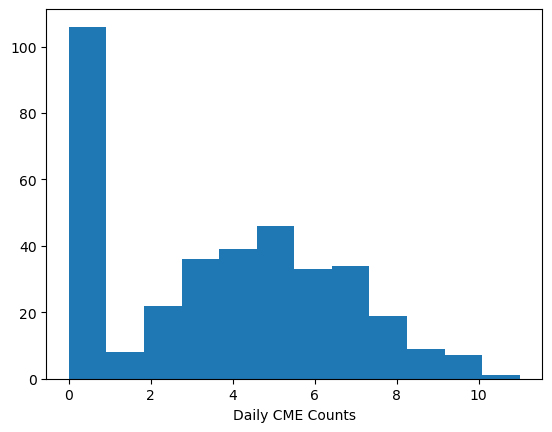

In [17]:
from scipy.stats import poisson, binom

np.random.seed(42)  # Set the seed to get same results each time

# function to generate CME counts
def gen_cme_counts(days):
    detect_TF = binom(1,0.7).rvs(days)
    daily_cmes = poisson(5).rvs(days)
    return detect_TF*daily_cmes

cme_counts = gen_cme_counts(360)
_ = plt.hist(cme_counts, bins=12)
_ = plt.xlabel('Daily CME Counts')

What happens if we try to estimate the average daily number using a Poisson model? 

The probability mass function for the Poisson distribution is:
$$
p(x\mid \lambda)=\frac{\lambda^x}{x!}exp(-\lambda).
$$
and we are interested in the rate parameter $\lambda$. The best estimator for $\lambda$ turns out to be the sample mean.

In [18]:
print('Mean number of CMEs {:1.1f}'.format(cme_counts.mean()))

Mean number of CMEs 3.6


We could throw out the zero results, but then we are removing a significant chunk of our data. If we then wanted to simulate CME counts in the future, our Poisson model is no good as it will under-estimate the number of days with zero counts.

One way to deal with this is to use a model called a zero-inflated Poisson model. This model generalizes the Poisson model by allowing for an overabundance of zero observations.

The probability distribution function for this is
$$
p(x\mid \pi,\lambda)=\pi\mathbb{I}(x=0)+(1-\pi)Pois(x\mid\lambda).
$$
Here $\mathbb{I}(x=0)$ is the indicator function, which is 1 when the condition is true and zero otherwise. This probability distribution is a combination of the two distributions, the Poisson and a distribution that generates zeros with probability $\pi$.

Hence:
$$
p(0\mid \pi,\lambda)=\pi+(1-\pi)exp(-\lambda)
$$
and
$$
p(x\neq0\mid \pi,\lambda)=(1-\pi)\frac{\lambda^x}{x!}exp(-\lambda).
$$


One can show that the log likelihood function for this process is given by
$$
\ln \mathcal{L}= nr_0\ln[\pi+(1-\pi)e^{-\lambda}]+n(1-r_0)[\ln(1-\pi)-\lambda]+n\bar{x}\ln\lambda
$$

where $r_0=\frac{1}{n}\sum_i\mathbb{I}(x_i=0)$ and $\bar{x}=\frac{1}{n}\sum_i x_i$.

Let us find the values of $\lambda$ and $\pi$ for out CME data. 

In [11]:
def neg_loglike_ZIP(theta, x):
    """
    Return zero-inflated Poisson negative log-likelihood

    Parameters
    ----------
    theta - model parameters
    x - 1d array
        count values 
    """

    N = len(x)
    mu = x.mean()
    r_0 = (x == 0 ).sum()/N
    lambd = theta[0]
    pi = theta[1]

    ll = N*r_0*np.log(pi+(1-pi)*np.exp(-lambd))+N*(1-r_0)*(np.log(1-pi)-lambd)+N*mu*np.log(lambd)

    return -1 * ll 

Perform a maximum likelihood calculation.

In [12]:
# guess parameters
theta_start = np.array([4, 0.3])

res = minimize(neg_loglike_ZIP, theta_start, method='Nelder-Mead',
               options={'disp': True}, args=(cme_counts))

Optimization terminated successfully.
         Current function value: -572.532889
         Iterations: 34
         Function evaluations: 64


In [19]:
print('Mean number of CMEs {:1.1f}'.format(res.x[0]))
print('Proportion of missed CMEs {:1.1f}'.format(res.x[1]))

Mean number of CMEs 5.0
Proportion of missed CMEs 0.3


Now plot the predicted and empirical distributions

In [21]:
from scipy.special import factorial

# calculates the PMF for the ZIP
def calc_prop_ZIP(xs, theta):
    lambd = theta[0]
    pi = theta[1]
    
    p_0 = pi+(1-pi)*np.exp(-lambd)
    p_x = (1-pi)*lambd**xs/factorial(xs)*np.exp(-lambd)
    return np.concatenate([[p_0], p_x])

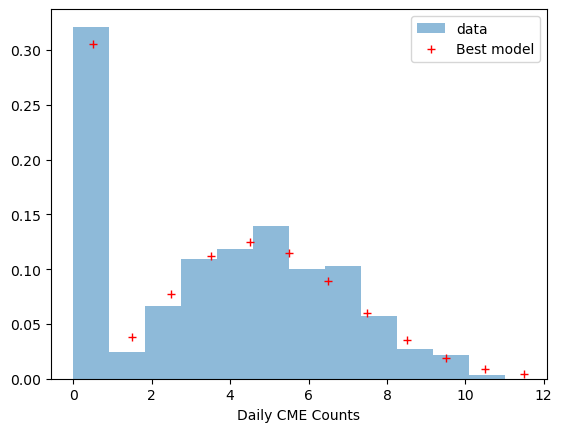

In [26]:
count_vals = np.arange(12)+0.5
pmf = calc_prop_ZIP(count_vals[1:], res.x)
_ = plt.hist(cme_counts, bins=12, density=True, alpha=0.5, label='data')
_ = plt.xlabel('Daily CME Counts')
_ = plt.plot(count_vals, pmf, '+', color='red', label='Best model')
_ = plt.legend()

## Cross-validation for model selection

Finally, we will take a look at another technique for selecting between models when fitting to data. In Lecture 3 we saw briefly the reduced $\chi^2$ method, which only really has limited applicability. The technique of cross-validation is much more widely applicable, as it relies on few assumptions about the nature of the data.

The main idea behind cross-validation is that we want to examine how well the model predicts new (or unseen) data. In the fitting methods we have discussed so far, we have used all our data in determining the best fit parameters. To replicate unseen data, what we can do is split our data in to $k$ separate subsets. We then fit to the model to all subsets but one (referred to as training data), and see how well the model predicts the subset not used in fitting (called the test data). We can then change which subset represents the test data, fit the model again to the new training data and predict on the new test data. We can repeat this $k$ times (see figure below).

<img src='https://upload.wikimedia.org/wikipedia/commons/b/b5/K-fold_cross_validation_EN.svg'>

Typically you refer to it as $k$-fold cross-validation, and when $k=N$ (i.e. is the same as the number of data points) this is leave one out cross-validation.

The prediction of the new data comes from using the likelihood with the best model parameters (determined from the training data) and calculating the probability of seeing the test data.

The steps to perform this are: 

* First, we randomly split the data into $k$ subsets. 

* The model is fit to the training data, which contains $k-1$ subsets.

* The probability of test data is calculated from the best fit model.

* This is repeated for all $k$ subsets, and the prediction probability is averaged. 


### Example

Let us look at an example of this with Normally distributed data (with the same uncertainty on each value) and using leave one out cross-validation. We will use the polynomial data we saw in lecture 2. 

Given that the log-likelihood for the normally distributed data is proportional to the squared residuals (e.g. Equation 4.3), we will use this to measure the prediction probability, i.e. $(\hat{y}_k-y_k)^2$, where $\hat{y}_k$ is the predicted value and $y_k$ is observed value in the test data.

In [27]:
# generate data
x = np.arange(-5, 5, 0.1)

# quartic model
y_mod = 1e-2*x**4 - 0.1*x**3+1e-1*x**2 + 0.05*x
y = y_mod + np.random.RandomState(10).randn(len(x))

In [28]:
# empty lists to store mean and std error of cv score
cv_score = []
cv_score_std = []

# degrees of polynomial models to try
for deg in range(10):

    cv_val = []

    # loop over all data
    for i in range(2, x.shape[0]):
        test_x, test_y = x[i], y[i]  # set ith point as test data

        train_x = np.concatenate((x[0:i], x[i+1:]))
        train_y = np.concatenate((y[0:i], y[i+1:]))

        # fit polynomial model via least-squares
        coeff = np.polyfit(train_x, train_y, deg)

        # predict
        y_pred = np.polyval(coeff, test_x)

        cv_val.append((y_pred-test_y)**2)

    cv_score.append(np.mean(cv_val))
    cv_score_std.append(np.std(cv_val)/len(cv_val)**0.5)


Min CV score 1.04 at degree 4


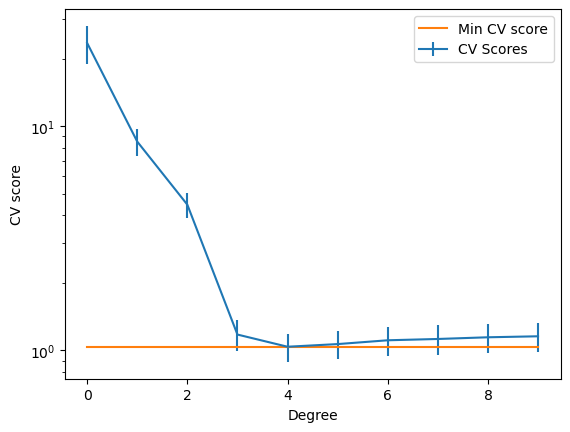

In [29]:
# figure code
# plot results
_ = plt.errorbar(np.arange(10), cv_score, yerr=cv_score_std, label='CV Scores')
_ = plt.plot([0, 9], np.min(cv_score)*np.ones(2), label='Min CV score')
_ = plt.ylabel('CV score')
_ = plt.xlabel("Degree")
_ = plt.yscale('log')
_ = plt.legend()

print("Min CV score {0:1.2f} at degree {1:1}".format(np.min(cv_score), np.argmin(cv_score)))

## References

1. [Hogg, Bovy and Lang \(2010\) https://arxiv.org/abs/1008.4686](https://arxiv.org/abs/1008.4686)

2. [Statistics, Data Mining and Machine Learning in Astronomy](http://www.astroml.org/_downloads/DMbookTOC.pdf), Ivezic et al (Chapter 4)

3. [Discussion of optimisers, SciPy Docs](https://scipy-lectures.org/advanced/mathematical_optimization/)

4. [In All Likelihood](https://www.amazon.co.uk/All-Likelihood-Statistical-Modelling-Inference/dp/0199671222), Pawitan, Chapter 2 (No freely accessible version of this..)

## Further Reading

These are some links that I found useful, discussing various implementations of MLE in Python. 

- [Different methods for MLE](https://rlhick.people.wm.edu/posts/estimating-custom-mle.html)

- [Fast MLE using automatic differentiation](https://rlhick.people.wm.edu/posts/mle-autograd.html)

- [Calculating the hessian](https://stats.stackexchange.com/questions/424073/calculate-the-uncertainty-of-a-mle)



## Questions


1. We have measured a light curve from a flaring region of the Sun. We believe that the curve oscillates in time, suggesting the presence of a periodic phenomena - [quasi periodic pulsation](https://link.springer.com/article/10.1007/s11214-021-00840-9). Measuring the properties of the oscillation will enable us to test it against our theories for why it occurs. 
   
   Our experimental equipment counts photons, which means that the uncertainty on the number of photons counted is modeled by a Poisson distribution. Use MLE to fit a sinusoidal model to the light curve.

   a) Read in the data using pandas from *light_curve.csv'* and plot the photon counts as a function of time.

   b) From the plot it looks like there is a constant level of photons modulated by a sinusoid. Define a function to model this that is compatible with `scipy.minimize`. The function return a sinusoid which has amplitude, period, phase, and a constant value as parameters to be estimated.

   c) Define a function to calculate the negative log-likelihood of Poisson distributed data. The negative log-likelihood is given by 
   $$
   \ln\mathcal{L}=\sum_i\left(-\lambda_i+x_i\ln\lambda_i-\ln(x_i!) \right).
   $$

   Note that $\lambda$ represents the mean value of distribution and $x_i$ is the observed data, where the $i$ refers to the measurement at $t_i$. Here the mean value is also depends on time, $\lambda=\lambda_i$. Look back at the lecture notes to see how we modified the Gaussian likelihood to include a varying mean function. 
   
   Also note that you do not need to include the third term in the summation. This is because it is a sum over the data only, hence is a constant - independent of the parameters. 

   d) Calculate the point estimates for the 4 unknown parameters in the model, using `scipy.minimize`. Check the returned best fit model parameters by over plotting the model on the data.

   e) Calculate the uncertainties on the point estimates using the Hessian.

<br>

2. Spicules are jets of chromospheric plasma that are seen almost everywhere across the Sun's disk. 
   <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/de/Halpha_%2B700_limb_spicules_08Aug2007_SST.png/800px-Halpha_%2B700_limb_spicules_08Aug2007_SST.png" width='30%'>
   There has been significant study of the properties of the spicules, with measurements of the acceleration, length, lifetime, etc.

   a) Read in the data 'spicules.csv' and plot the lifetime against max height.
   
   b) Fit a straight line to the data using `curve_fit` from `scipy`.

   The data we obtain may contain points that are considered to be [outliers](https://en.wikipedia.org/wiki/Outlier). These are points that are significantly different from the other observations. These points are not necessarily bad data, and could be indicators of phenomenon not currently known about (or included in the model). Regardless of their origin, if your data contains outliers of unknown origin, then they should be accounted for.
   
   If you look at the spicule data you plotted in Question 2a, the are three data points that are not located near the others. 
   
   In the following you will use a MLE approach to account for these outliers.
   
   The least squares method used by `curve_fit` assumes that the data is normally distributed. The presence of outliers invalidates this assumptions. The outliers can be accounted for by using a 'heavy-tailed' distribution, for example the [Student T distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).
   
   c) The following function is the log-likelihood of the non-centralised Student-T distribution:
   $$
   \ln\mathcal{L} = \ln \Gamma(\frac{\nu + 1}{2})-\ln\Gamma(\frac{\nu}{2})-0.5\ln\pi      \nu-\frac{\nu+1}{2}\ln\left[1+\frac{\xi^2}{\nu}\right]-\ln(\lambda),
   $$
   where
   $$
    \xi=\frac{(x-\mu)}{\lambda},
   $$
   $\mu$ is the mean, $\lambda$ is a scale parameter, $\nu$ is the degrees of freedom,
   and $\Gamma()$ is the Gamma function. Create a function that returns the negative log-likelihood for the non-centralised Student-T. Your function should have the scale and degrees of freedom as parameters to estimate, along with the gradient and intercept of a straight line. Note, $\mu$ should be a varying mean function.
   
   d) Calculate the point estimates for the 4 unknown parameters in the model, using `scipy.minimize` and your negative log-likelihood function. 
   
   e) Compare the best fit lines obtained in parts b) and d).

<br>
   
3. For our example of measuring the voltage in Section 4.2, show that the MLE estimator for the voltage is given by the arithmetic mean (i.e. prove Eq 4.5). And, show the uncertainty on this value is given by the standard error (i.e. prove Eq 4.9).

<br>

4. Show that the log-likelihood for $N$ data points that are generated by a [Poisson process](https://en.wikipedia.org/wiki/Poisson_distribution), where the probability mass function is $$P(x,\lambda)=\frac{e^{-\lambda}\lambda^x}{x!},$$ 
is the that given in Question 1c. Here $\lambda$ is the shape parameter and $x$ is the random variable.

<br>

5. Show that the MLE estimator for the shape parameter of the Poisson distribution is 
$$\lambda =\frac{\sum_{i=1}^N x_i}{N}.$$

6. For a smaller number of observed data points, typically our estimates for the model parameters are worse. More data points leads to better estimates. Why do you think this is? 



